# Lesson 2 Notes
In this lesson, we walked through the lesson 1 notebook in more detail, and then looked at other notebooks that showed similar examples of using convolutional neural nets (CNNs) to perform image recognition.

Notebooks covered:
1. lesson1.ipynb
2. lesson1-rxt50.ipynb
3. lesson2-images_models.ipynb

This lesson mainly covered the high level steps to create an effective image recognizer (more details will be covered later).

## 1. Import libraries
First we import the fast.ai libraries.

They are wrappers for PyTorch, which is Facebook's machine learning library.

In [2]:
# Notebook "magic" commands -- graph plots inline, etc.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Import libraries
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

## 2. Setup a path to your data

Next we set up a path to our data.
Data must be stored in a specific hierarchy. There should be folders for:

1. `Training`: These images will be labelled and will be used to find the correct weights required to recognize the different image classes (e.g., cat or dog)
2. `Validation`: These images are also labelled and will be used to test how good the neural network is after training has finished

Each of these folders contains a subfolder for each class we want to recognize. For example, if we wanted to recognize cats and dogs, the hierarchy would look like this:

1. Training
    * Cats
        * cat.001.jpg
        * ...
    * Dogs
        * dog.001.jpg
        * ...
2. Validation
    * Cats
        * cat.001.jpg
        * ...
    * Dogs
        * dog.001.jpg
        * ...

A good practice exercise is to set up your own folder structure with some images that you want to recognize.

In [19]:
# Set up our path
PATH = "data/dogscats/"

In [20]:
# We must also specify the size of the images, although I'm not clear how exactly size affects learning.
# You will do fewer convolutions?
size=224

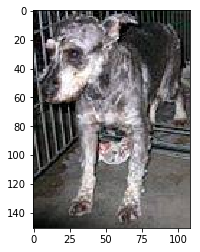

In [37]:
# Example dog image
files = !ls {PATH}valid/dogs

dog_img = plt.imread(f'{PATH}valid/dogs/{files[0]}')
plt.imshow(dog_img)

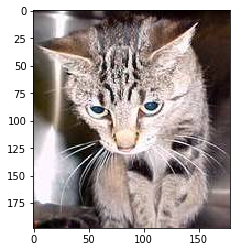

In [38]:
# Example bird image
files = !ls {PATH}valid/cats

cat_img = plt.imread(f'{PATH}/valid/cats/{files[0]}')
plt.imshow(cat_img)

## 3. Set up your architecture
After creating our directory structure, we must choose a neural net architecture to use.

We use resnet 34 (resnet = residual neural network, a convolutional neural network)

In [23]:
architecture = resnet34

## 4.Create transforms/data augmentation
When we train our neural network, sometimes we get what is called __overfitting__. This is when the network becomes very good at recognizing the training data, but not so good at recognizing the validation data. It cannot generalize.

You can tell if your model is overfitting because the loss for the training data will be quite a bit lower than the loss for the validation data.

### A Note on Loss
Loss, also known as cost, is a measure of how good your neural network is. The lower the loss, the better.

There is a function that calculates loss by measuring the difference between what something is labelled as, and what the network thinks it is.

We try to set the weights in the neural network to minimize this function. We do this via a process known as stochastic gradient descent (SDG).

## Back to transforms...using them to augment data
One way to solve overfitting is to pass in more training data. But what if we don't have any more? Or don't want to spend more time doing this?

__Solution:__
To create more training data, simply __transform__ our existing training data. For example, crop it, zoom it, rotate it, flip it, etc. Think of it like giving the neural network a different way of looking at the same data.

Getting extra data in this way is called __data augmentation__.

In [24]:
# In code, we create our transforms like this
transforms = tfms_from_model(architecture, size)

In [25]:
# Now that we have our data path and transforms set up, we can initialize our data like this:
data = ImageClassifierData.from_paths(PATH, tfms=transforms)

## 5. Initialize your neural network learner
Now that we have our data and architecture initialized, we can initialize our "learner". The thing that will learn the correct weights to detect our image classes, and can be used to detect them.

In [26]:
learn = ConvLearner.pretrained(architecture, data, precompute=True)

### What Does "Pretrained" mean?
The `.pretrained` call means that our convolutional neural network has been trained already (in this case, on image-net data). This means it has a number of layers set up to recognize increasingly complex things. The first layer can recognize corners, edges, etc., a later layer can recognize bird eyes or flower petals, etc.

What we will do is just add a final layer on to this with just two outputs -- one for each of the classes we want to recognize.

Initially, we will just be setting the weights for this final layer.

In the diagram below, you can see how the final layer has been set to recognize 10 different things.

<img src="https://image.slidesharecdn.com/practicaldeeplearning-160329181459/95/practical-deep-learning-16-638.jpg">

## 6. The learning rate and finding it
In a neural network, we want to minimize our loss function. We do this by calculating the gradient, and then stepping down the gradient by a certain amount. Imagine it like walking down a hill. Looking to see where the next steepest slope is, and then stepping down that slope by a certain distance. Repeat. The amount you step down by -- multiply the gradient by -- is known as the __learning rate__, since it describes how much we're improving our weights by to minimize the loss function. It is like the network is "learning".

But how do you know what the learning rate should be?

Too high and you might miss the minimum -- you could step over it and start going up again.

Too low and you will take forever to reach the minimum -- or you might never reach it.

We use a technique which involves doubling the learning rate each time until the loss starts increasing again, and then using the learning rate __before__ the loss flattened out/started increasing.

I.e., use the largest rate that still causes a decrease in loss. This way you optimize stepping down quickly, while still minimizing loss.

<img src="https://raw.githubusercontent.com/pekoto/fast.ai/master/images/find-lr.jpg" width=400 height=300>

In [28]:
# We can use this algorithm to find the learning rate like this
# The code will stop running when it finds the optimum learning rate, so don't worry if it doesn't run until 100%
learning_rate_finder = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 79%|███████▉  | 284/360 [00:05<00:01, 53.77it/s, loss=0.44] 


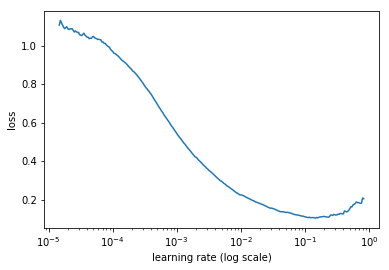

In [29]:
learn.sched.plot()

Take a look at the plot above. You can see the learning rate keeps decreasing until about $10^{-1}$. At $10^{-1}$ it starts to 
flatten out then increase. So we step back and use $10^{-2}$ as our learning rate ($10^{-2} = 0.01$).

### Note on log scales
Note the chart above uses a __log scale__. In a log scale, instead of every data point (tick) being seperated by a constant -- like, say, 50 apart -- each data point is a multiple of the previous data point. It makes it easier to visualize a wide spread of data.

Also not that:

* $10^{-1} = 0.1 = 1e-1$ (Python)
* $10^{-2} = 0.01 = 1e-2$ (Python)
* $10^{-3} = 0.001 = 1e-3$ (Python)
* ...etc.

## 7. Training our layer!
Now that we have data set up and our learning rate decided, we can train our final layer to recognize our images.

This process is essentially going to run through all of our data a certain number of times. The number of times it runs through our data is called an __epoch__.

The second parameter passed in here is the number of epochs we are going to run.

Running too many epochs can lead to overfitting (when the network is good at recognizing training images, but less good at recognizing validation images). Reminder: You can tell when you are overfitting because the loss for training will be quite a bit lower than the loss for validation.

One technique is to run the network until it's overfitting, then decrease the epochs until it stops overfitting.

In [30]:
# The output will be of the format
# [Epoch number.     training loss/validation loss/accuracy] 
# Accuracy is the ratio of correct predictions to actual number of those classes (i.e., % correct images identified)
learn.fit(0.01, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[0.      0.04912 0.02528 0.98926]                             
[1.      0.04673 0.02355 0.99072]                             
[2.      0.03448 0.0265  0.99023]                             



The network will output 1 for something it thinks is 100% a dog, 0 for something it thinks is 100% a cat, and somewhere inbetween depending on how sure it is. See `lesson1.ipynb` for examples.

## 8. Train with data augmentation and with cycle_len
In our training above, our learner was initialized with `precompute=True`. This means the precomputed weights for the early layers -- the layers that recognize edges, etc., -- were locked down. This means we couldn't use data augmentation (our transformed training data). (Why?)

Now we will unfreeze our earlier layers so we can use data augmentation too.

### 8.1 cycle_len/SGDR/annealing
When training, we often reduce our learning rate as the cost function minimizes -- as we process more and more batches (iterations) of data. This is so we don't overshoot our minimum point. Think of it like driving a car. At first we drive fast to get roughly to where we want to go, then we slow down as we reach the point we want to get to to allow us to be more accurate.

This process of decreasing the learning rate as we go on is called __learning rate annealing__.

However, there is a problem: if our function is "spiky" -- we have lots of spiky troughs -- we could get stuck in a spiky area that doesn't generalize well. We want to get to a part of our function that is a minima, but that is not too spiky, so we can generalize to different classes. Our cost function will change slightly given different input classes.

One way to achieve this is __Stochastic Gradient Descent with Restarts__ (__SGDR__).

This means that we decrease the learning rate (from the rate we found initially) as the epoch progresses -- as we process our batches -- but then at the end of the epoch, we reset it to our initial learning rate so we don't get stuck in a spiky local minima.

The `cycle_len` parameter tells us the number of times we do these resets. E.g., `cycle_len=1` means reset the learning rate for every epoch. `cycle_len=2` means reset the learning rate every 2 epochs, etc.

Incidentally, a function that works well for decreasing the learning is to use half a cosine curve. We call that __cosine annealing__.

<img src="https://raw.githubusercontent.com/pekoto/fast.ai/master/images/cos-annealing.jpg">

In [32]:
# So let's set precompute to false and train again
learn.precompute=False
learn.fit(0.01, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[0.      0.0277  0.02558 0.99072]                             
[1.      0.03079 0.02943 0.98779]                             
[2.      0.02677 0.02855 0.98877]                             



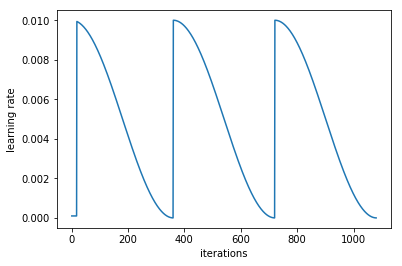

In [33]:
# If we plot the learning rate now, we can see that it gets reset every epoch
learn.sched.plot_lr()

## 9. Test Time Augmentation (TTA)
When validating, the convolutional network looks at a square section of the image. But what is the image is rectangular, for example? The network might end up looking at a black blob that it can't tell if it's a cat or dog. One way to mitigate this problem is to pad the image our with mirror copies of sections to make it square. Another solution is to use __test time augmentation__.

Test time augmentation (TTA) means also augmenting -- transforming (e.g., scaling, taking a certain section, etc.) -- the image at test time too. So we could do 4 transforms of the image during validation, predict which each one is, and then take the mean of the predictions. Jeremy mentions this typically gives a 10-20% error reduction.



In [35]:
log_predictions,y = learn.TTA()
# Convert probabilites from a log scale and take the average
probabilities = np.mean(np.exp(log_predictions), 0)

accuracy(probabilities, y)

0.99

## 10. Fine tuning the other layers (differential learning rates)
Now, we have a pretty good final layer, but we might want to tune the earlier, pre-training layers too.

BUT, these layers have already been trained and are for spotting more general purpose features -- we don't want to mess with them too much, so we use different (lower) learning rates for them. For example, for the early layers we might use $10^{-4}$ and for the layers in between we might use $10^{-3}$.

In [36]:
# Unfreeze the earlier layers
learn.unfreeze()

# Set up different learning rates for different layers
# The more general the layer, the lower the learning rate
differential_learning_rates = np.array([0.0001, 0.001, 0.01])

# Run with our new learning rates
learn.fit(differential_learning_rates, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[0.      0.04295 0.02439 0.99072]                             
[1.      0.0185  0.02117 0.99121]                             
[2.      0.01389 0.02294 0.99072]                             
[3.      0.01512 0.02245 0.9917 ]                             
[4.      0.00867 0.02173 0.99219]                              
[5.      0.00591 0.02184 0.99121]                              
[6.      0.00465 0.02207 0.99219]                              



## 11. Cycle_mult
Note that in the above we set the `cycle_mult` parameters. This multiplies the subsequent epochs and decreases the learning rate over these epochs.

For example, we ran epoch 0 (1 epoch) and decreased the learning rate over that epoch.

Then for our next run, we used 2 epochs (1*2) and decreased the learning rate over those before resetting it.

Then for our next run, we used 4 epochs (2*2) and decreased the learning rate over those.

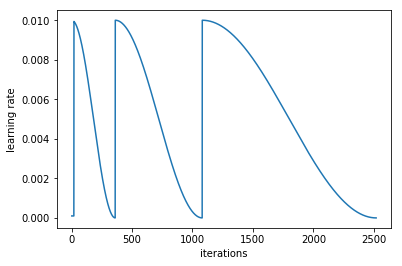

In [39]:
learn.sched.plot_lr()